# Introduction
In this notebook we aim to simulate the orbital evolution of a planet in the presense of an additional force. We update accelerations which have been forced by arbitrary functions of $\dot{e}$ and $\dot{a}$. Equations used throughout this program are based on [Wolff, Dawson, & Murray-Clay (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/746/2/171/pdf), hereafter referenced as WDMC. (See also Chapter 2 of Murray & Dermott.) For reference, a page of this paper's appendix containing the relevant equations is shown in a cell below. 

## Orbital Evolution: Python and REBOUND

To test the accuracy of the program, arbitrary functions are assigned to eccentricity and its time-evolution. They may include, for example, 

$$ e(t) = A e_0 \left[\sin{\left(\frac{2\pi t}{\tau}\right)} + 1 \right]\ \Rightarrow \ \dot{e} = \frac{2\pi A e_0}{\tau} \cos{\left(\frac{2\pi t}{\tau}\right)}\  $$

where $A$ is some constant.

In [1]:
%matplotlib inline
import os
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
from matplotlib.ticker import FormatStrFormatter

In [2]:
#...Get eccentricity results from Mercury:
path = 'mercury' #/gpfs/group/rxd44/default/len56/mercury/
if os.path.exists(path+'/plan1.aei'):
    os.rename(path+'/plan1.aei',path+'/plan1.txt')
f = open(path+'/plan1.txt', 'r').readlines()[4:]
Nout = len(f)
eccentricity_mer = np.zeros(Nout)
times_mer = np.zeros(Nout)
for i in range(0,Nout):
    w = f[i].split()
    times_mer[i] = w[0]
    eccentricity_mer[i] = w[2]

In [3]:
def orbital_evolution(reb_sim,rebx_effect,dt,timing):
    sim = reb_sim.contents
    time = sim.t
    ps = sim.particles
    year = 2.0*np.pi #...Converts years to rad: 1 = (2pi rad)/(1 year)
    days = 2.0*np.pi/365.25 #...Converts days to rad: 1 = (2pi rad)/(365 days)
    
    #...Initialize acceleration & velocity at zero:
    ax,ay,az = 0.0,0.0,0.0
    vux,vuy,vuz = 0.0,0.0,0.0

    #...Get orbital parameters:
    x,y,z = ps[1].x, ps[1].y, ps[1].z
    vx,vy,vz = ps[1].vx, ps[1].vy, ps[1].vz
    P = ps[1].P #...period
    n = ps[1].n #...mean motion
    semi = ps[1].a #...Semimajor axis
    e = ps[1].e #...Eccentricity
    inc = ps[1].inc #...inclination 
    Ω = ps[1].Omega #...longitude of ascending Ω
    ω = ps[1].omega #...argument of pericenter
    pomega = ps[1].pomega #...longitude of pericenter
    f = ps[1].f #...true anomaly
    Manom = ps[1].M #...mean anomaly
    msum = ps[0].m + ps[1].m
    
    #...Setup eccentricity evolution
    tau = 365.25e5*days
    e0 = 0.5
    edot = (2.0*np.pi*e0/tau)*np.cos(2.0*np.pi*time/tau)
    edotovere = edot/e
    adotovera = 0.0
    idotoveri = 0.0

    ###---BEGIN ORBITAL EVOLUTION CALCULATIONS---###
    # WDMC: https://iopscience.iop.org/article/10.1088/0004-637X/746/2/171/pdf
    
    if edotovere != 0.0:
        #...Orbital equations: WDMC (A5 - A8)
        r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f)) 
        rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
        drdotde = rdot/(e*(1.0-e**2.0))
        rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f))
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))

    #...Calculate acceleration & velocity: WDMC (A12 - A14) and (A9 - A11)
    ax += (-vx + 3.0*z*idotoveri*inc*math.sin(Ω))/2.0*adotovera
    ay += (-vy - 3.0*z*idotoveri*inc*math.cos(Ω))/2.0*adotovera
    az += -(vz + 3.0*idotoveri*inc*z)/2.0*adotovera #...from mfo_user.for 
    vux += x*adotovera 
    vuy += y*adotovera 
    vuz += z*adotovera
    
    if edotovere != 0.0 and e < 1.0 and e > 0.0:
        #...Calculate acceleration & velocity: WDMC (A12 - A14)
        ax += (math.cos(Ω)*(drdotde*math.cos(ω+f) - drfdotde*math.sin(ω+f)) - math.sin(Ω)*(drdotde*math.cos(inc)*math.sin(ω+f) + drfdotde*math.cos(inc)*math.cos(ω+f)) - idotoveri*inc*drde*z/r)*edotovere*e  
        ay += (math.sin(Ω)*(drdotde*math.cos(ω+f) - drfdotde*math.sin(ω+f)) + math.cos(Ω)*(drdotde*math.cos(inc)*math.sin(ω+f) + drfdotde*math.cos(inc)*math.cos(ω+f)) - idotoveri*inc*drde*z/r)*edotovere*e 
        az += (drdotde*math.sin(inc)*math.sin(ω+f) + drfdotde*math.sin(inc)*math.cos(ω+f) + drde*idotoveri*inc*math.cos(inc)*math.sin(ω+f))*edotovere*e
        vux += (r/semi/(1.0-e**2.0) - (1.0+e**2.0)/(1.0-e**2.0))*x*edotovere
        vuy += (r/semi/(1.0-e**2.0) - (1.0+e**2.0)/(1.0-e**2.0))*y*edotovere
        vuz += (r/semi/(1.0-e**2.0) - (1.0+e**2.0)/(1.0-e**2.0))*z*edotovere

    if idotoveri != 0.0:
        ax += math.sin(Ω)*(vz + idotoveri*z)*idotoveri*inc
        ay += -math.cos(Ω)*(vz + idotoveri*z)*idotoveri*inc
        az += (rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f) + r*idotoveri*math.cos(inc)*math.sin(ω+f) - idotoveri*inc*z)*idotoveri*inc
        vux += z*math.sin(Ω)*idotoveri*inc
        vuy += -z*math.cos(Ω)*idotoveri*inc
        vuz += (-math.sin(Ω)*x + math.cos(Ω)*y)*idotoveri*inc
            
    #...Update acceleration & velocity
    ps[1].ax += ax.real
    ps[1].ay += ay.real
    ps[1].az += az.real
    #ps[1].vx += vux.real
    #ps[1].vy += vuy.real
    #ps[1].vz += vuz.real

In [4]:
force_is_velocity_dependent = True
def orbital_evolution2(reb_sim, rebx_effect, particles, N):
    sim = reb_sim.contents
    effect = rebx_effect.contents
    time = sim.t
    ps = sim.particles
    year = 2.0*np.pi #...Converts years to rad: 1 = (2pi rad)/(1 year)
    days = 2.0*np.pi/365.25 #...Converts days to rad: 1 = (2pi rad)/(365 days)
    
    adotovera=0.0
    ax = 0.0
    ay = 0.0
    az = 0.0
    vux = 0.0
    vuy = 0.0
    vuz = 0.0
    
    #...Get orbital parameters:
    x,y,z = ps[1].x, ps[1].y, ps[1].z
    vx,vy,vz = ps[1].vx, ps[1].vy, ps[1].vz
    P = ps[1].P #...period
    n = ps[1].n #...mean motion
    semi = ps[1].a #...Semimajor axis
    e = ps[1].e #...Eccentricity
    periq = semi*(1.0-e)
    inc = ps[1].inc #...inclination 
    node = ps[1].Omega #...longitude of ascending Ω
    peri = ps[1].omega #...argument of pericenter
    pomega = ps[1].pomega #...longitude of pericenter
    f = ps[1].f #...true anomaly
    Manom = ps[1].M #...mean anomaly
    msum = ps[0].m + ps[1].m
    
    tau=3.6525e7*days
    e0=0.5
    edotovere=(2.0*np.pi*e0/tau)*math.cos(2.0*np.pi*time/tau)/e
    idotoveri =0.0

    if edotovere != 0.0:
        if e == 0.0: 
            f = Manom
        else:
            temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2) - 1.0) /e
            temp = math.copysign(min(abs(temp),1.0),temp)
            f = math.acos(temp)
            if math.sin(Manom) < 0.0:
                f = 2.0*np.pi - f

        r = semi * (1.0-e**2.0)/(1.0+e*math.cos(f))
        rdot = math.sqrt(msum)*semi**(-1.0/2)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2)
        drdotde = rdot/(e*(1.0-e**2.0))
        rfdot = math.sqrt(msum)*semi**(-1.0/2)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))


    ax =  -(vx+3.0*idotoveri*inc*z)/2.0*adotovera
    ay =  -(vy-3.0*idotoveri*inc*z)/2.0*adotovera
    az =  -(vz+3.0*idotoveri*inc*z)/2.0*adotovera
    vux = x*adotovera
    vuy = y*adotovera
    vuz = z*adotovera

    if edotovere != 0 and e < 1 and e > 0:
        ax = ax + (math.cos(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f)) - math.sin(node)*(drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e   
        ay = ay + (math.sin(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))+ math.cos(node)*(drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e
        az = az + (drdotde*math.sin(inc)*math.sin(peri+f)+drfdotde*math.sin(inc)*math.cos(peri+f)+drde*math.cos(inc)*math.sin(peri+f)*idotoveri*inc)*edotovere*e
        vux = vux + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*x*edotovere
        vuy = vuy + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*y*edotovere
        vuz = vuz + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*z*edotovere

    if idotoveri != 0:
        ax = ax + math.sin(node)*(vz+z*idotoveri)*idotoveri*inc
        ay = ay +  - math.cos(node)*(vz+z*idotoveri)*idotoveri*inc
        az = az+((-math.sin(node)*vx+math.cos(node)*vy)+idotoveri*(-math.sin(node)*x+math.cos(node)*y))*idotoveri*inc
        vux = vux+z*math.sin(node)*inc*idotoveri
        vuy = vuy-z*math.cos(node)*inc*idotoveri
        vuz = vuz+(-x*math.sin(node)+y*math.cos(node))*inc*idotoveri

    ps[1].ax += ax
    ps[1].ay += ay
    ps[1].az += az
    #ps[1].vx += vux
    #ps[1].vy += vuy
    #ps[1].vz += vuz

In [5]:
#...Run simulation
sim = rebound.Simulation()
sim.add(m=1.0)
sim.add(m=0.0,a=0.2,e=0.5,inc=np.radians(45.0),omega=0.0,Omega=0.0,M=0.0)
ps = sim.particles
sim.integrator = "ias15"
times = np.arange(0.0,250.0+1,1)*2.0*np.pi/365.25 #...convert from unit days for compatibility with Mercury
Nout = len(times)
eccentricity_reb = np.zeros(Nout)

rebx = reboundx.Extras(sim)
myforce = rebx.create_force("orbital")
myforce.force_type = "vel"
myforce.update_accelerations = orbital_evolution2
rebx.add_force(myforce)
#custom_effect = rebx.add_custom_force(orbital_evolution2, force_is_velocity_dependent)
#custom_effect.force_is_velocity_dependent = 1
for i,t in enumerate(times):
    sim.integrate(t)
    eccentricity_reb[i] = ps[1].e

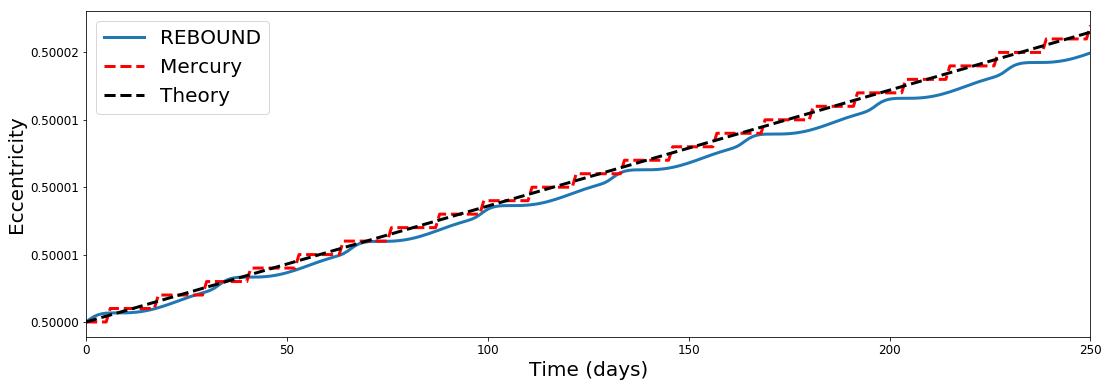

In [6]:
#...Plot results
days = 2.0*np.pi/365.25 #...Converts days to rad: 1 = (2pi rad)/(365 days)
e0 = 0.5
A = 1.0
tau = 365.25e5
eccentricity_theory = e0*(np.sin(2.0*np.pi*times/days/tau) + 1.0)


s=3
fig, ax1 = plt.subplots(1, 1, sharex=True,figsize=(6*s,2*s))
plt.subplots_adjust(wspace=0, hspace=0.1)
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)
linewidth=3.0
legend_size=20
labelsize=12
fontsize=16
sigfigs = '%.5f'


ax1.plot(times/days,eccentricity_reb,label='REBOUND',linewidth=linewidth)
ax1.plot(times_mer,eccentricity_mer,'--',label='Mercury',color='red',linewidth=linewidth)
ax1.plot(times/days,eccentricity_theory,'--',label='Theory',color='black',linewidth=linewidth)


ax1.set_ylabel('Eccentricity',fontsize=20)
#ax1.set_ylim(0.49999,0.50003)
ax1.legend(prop={'size': legend_size})
ax1.tick_params(axis="y", labelsize=labelsize)
ax1.ticklabel_format(useOffset=False)
ax1.yaxis.set_major_formatter(FormatStrFormatter(sigfigs))
ax1.tick_params(axis="x", labelsize=labelsize)
ax1.set_xlabel('Time (days)',fontsize=20)

dir_name = "plots/"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".pdf"):
        os.remove(os.path.join(dir_name, item))

savetag = 'orbital_evolution'
savetype = '.pdf'
#plt.savefig('plots/'+savetag+savetype,dpi=200,bbox_inches='tight')

## Questions

- Mercury has a set timestep. However, in REBOUND, according to documentation, the timestep will change for IAS15, since it is an adaptive integrator. Will this be an issue? 


- Why is the $z$ component of acceleration in Mercury different from WDMC Eq. (A14)?


- The velocity terms

    ```python
    vux += (r/semi - 1.0 - ecc**2.0)*x/(1.0-ecc**2.0)*edotovere
    ```
    
    are very small fractions of the planet's instantaeous velocity. Fractions start on the order of $10^{-5}$ and remain at $10^{-7}$ or smaller for the substantial remainder of integration time. The same is true for the additional acceleration terms; they are characteristically millions of times smaller than instantaneous accelerations. Are such small additions to velocity and acceleration expected? or do we expect larger magnitudes? Could there be a conversion factor(s) that needs to be incorporated somewhere?


- Should an `else` statement that updates accelerations and velocities be added as a counterpart to the

    ```python
    if edotovere != 0.0 and ecc < 1.0 and ecc > 0.0:
    ```
    
    statement?
    

- Where should

    ```python
    sim.move_to_com()
    ```
    
    be incorporated? According to the [documentation](https://github.com/dtamayo/reboundx/blob/master/ipython_examples/Custom_Effects.ipynb), it looks like it should be called once, when particles are initially added to the system. Should it be called in the for-loop, right before `sim.integrate(t)`?

## Notes

- In a current version of code which inputs $\tau = 10^9$, the runtime for 10 years of integration is 50 seconds. Assuming linear scaling, 10,000 years of integration time should take a runtime of about 14 hours.



- Velocities $\{\dot{x},\dot{y},\dot{z}\}$ may be calculated using equations WDMC (A2), or they may be retrieved by `REBOUND` using

    ```python
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz
    ```
    
    Print statements in the orbital evolution module appear to show that the difference between the values in each component are negligible, on the order of 1e-13 or smaller. For consistency, one could argue a prefernce for explicit calculation. But `REBOUND` retrieves velocities conveniently and with ease.
    
    
- Equations WDMC (A5) are translated as

    ```python 
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f)) 
    ```
    
    But these forms resulted in `math domain error` messages in previous versions. Equivalent expressions 
    
    ```python
    rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
    rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
    ```
    from `MFO_USER.FOR` have instead been adopted. Note that mean motion is
    
    $$n = \sqrt{\frac{G(M_{\star}+M)}{a^3}}\ .$$ 
    
    
- In `Mercury`, the argument of pericenter is 

    ```python
    ω = (pomega - node + 2.0*np.pi) % 2.0*np.pi
    ```
    
   The true anomaly is 

    ```python
    if e == 0.0:
        f = Manom
    else:
        temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0)/e
        temp = math.copysign(min(abs(temp),1.0),temp)
        f = math.acos(temp)
        if math.sin(Manom) < 0.0:
            f = 2.*np.pi - f
    ```
    
    In `REBOUND`,
    
    ```python
    ω = ps[1].omega
    ```
    
   and

    ```python
    f = ps[1].f
    ```
    
    Thus, between the two sets of definitions, there are four possible combinations of argument of pericenter with true anomaly. However, in principle, the two types of definitions should be numerically equivalent.
    
    
- One of the most recurrent error messages was

    ```python
    "TypeError: can't convert complex to float"
    ```
    
    which references the acceleration line

    ```python
    sim.particles[1].ax += ax
    ```
    
    It appears that the sources of error were variables `vx vy vz`, which are rooted in velocities
    
    ```python
    xdot = math.cos(node)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) - math.sin(node)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
    ydot = math.sin(node)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) + math.cos(node)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
    zdot = rdot*math.sin(inc)*math.sin(ω+f) + rfdot*math.sin(inc)*math.cos(ω+f)
    ```
    
    from WDMC equation (A2). A `print` statement reveals that sometimes these lines result in very small complex values, e.g. `(-2.99-3.67e-16j)`. To circumvent this error, only the real part of velocity was passed, using, for example, 
    
    ```python
    vx = xdot.real
    ```   
    
- Integration times may be retrieved from Mercury using the following lines:

    ```python
    f = open('/gpfs/group/rxd44/default/len56/mercury/param.in', 'r').readlines()
    start_time = float(f[6].split()[3].replace('d',''))
    stop_time = float(f[7].split()[4].replace('d',''))
    output_interval = float(f[8].split()[4])
    times = np.arange(start_time,stop_time+1,output_interval)
    timestep = float(f[9].split()[3])
    ```
    
- To run the Mercury scripts on the command line, use the line `./myscript; ./mercury6; ./element6`

## Scratch space
The cell below serves as scratch space for modifications to code.

# Appendix from WDMC
![Image of Wolff et al. (2012) paper](WolffEquations.png)

# Understanding `mercury6_2.for`

The two subroutines in the Fortran program `mercury6_2.for` which concern us here are `MCO_X2EL.FOR` and `MFO_USER.FOR`. They contain equations sourced in Murray & Dermott (MD), who in chapter 2.8 write,

> We can now summarize an algorithm for transforming the position $(X,Y,Z)$ and velocity
$(\dot{X}, \dot{Y}, \dot{Z})$ of an object in an elliptical orbit in the standard reference
plane at a time $t$ to a set of six orbital elements, $a$, $e$, $I$, $\Omega$, $\omega$, and $f$,
and a time of pericenter passage, $\tau$.

Below is shown `MCO_X2EL.FOR` with additional in-line comments that reference equations from the text. 

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MCO_X2EL.FOR    (ErikSoft  23 January 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Calculates Keplerian orbital elements given relative coordinates and
! velocities, and GM = G times the sum of the masses.
!
! The elements are: q = perihelion distance
!                   e = eccentricity
!                   i = inclination
!                   p = longitude of perihelion (NOT argument of perihelion!!)
!                   n = longitude of ascending node
!                   l = mean anomaly (or mean longitude if e < 1.e-8)
!
!------------------------------------------------------------------------------
!
      subroutine mco_x2el (gm,x,y,z,u,v,w,q,e,i,p,n,l)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      real*8 gm,q,e,i,p,n,l,x,y,z,u,v,w
!
! Local
      real*8 hx,hy,hz,h2,h,v2,r,rv,s,true
      real*8 ci,to,temp,tmp2,bige,f,cf,ce
!
!------------------------------------------------------------------------------
!
      hx = y * w  -  z * v ! MD (2.129)
      hy = z * u  -  x * w ! MD (2.129)
      hz = x * v  -  y * u ! MD (2.129)
      h2 = hx*hx + hy*hy + hz*hz ! MD (2.129)
      v2 = u * u  +  v * v  +  w * w ! MD (2.127)
      rv = x * u  +  y * v  +  z * w ! MD (2.128)
      r = sqrt(x*x + y*y + z*z) ! MD (2.126)
      h = sqrt(h2) ! MD (2.129)
      s = h2 / gm ! see MD (2.134) and (2.135)
!
! Inclination and node
      ci = hz / h ! MD (2.136)
      if (abs(ci).lt.1) then
        i = acos (ci) ! MD (2.136)
        n = atan2 (hx,-hy) ! MD (2.137)
        if (n.lt.0) n = n + TWOPI
      else
        if (ci.gt.0) i = 0.d0
        if (ci.lt.0) i = PI
        n = 0.d0
      end if
!
! Eccentricity and perihelion distance
      temp = 1.d0  +  s * (v2 / gm  -  2.d0 / r) ! MD (2.134) and (2.135)
      if (temp.le.0) then
        e = 0.d0
      else
        e = sqrt (temp) ! MD (2.134) and (2.135)
      end if
      q = s / (1.d0 + e) ! perihelion distance; see note below
!
! True longitude (aka θ; see MD chapter 2.3)
      if (hy.ne.0) then
        to = -hx/hy
        temp = (1.d0 - ci) * to
        tmp2 = to * to
        true = atan2((y*(1.d0+tmp2*ci)-x*temp),(x*(tmp2+ci)-y*temp))
      else
        true = atan2(y * ci, x)
      end if
      if (ci.lt.0) true = true + PI
!
      if (e.lt.3.d-8) then
        p = 0.d0
        l = true
      else
        ce = (v2*r - gm) / (e*gm)
!
! Mean anomaly for ellipse
        if (e.lt.1) then
          if (abs(ce).gt.1) ce = sign(1.d0,ce)
          bige = acos(ce)
          if (rv.lt.0) bige = TWOPI - bige
          l = bige - e*sin(bige)
        else
!
! Mean anomaly for hyperbola
          if (ce.lt.1) ce = 1.d0
          bige = log( ce + sqrt(ce*ce-1.d0) )
          if (rv.lt.0) bige = - bige
          l = e*sinh(bige) - bige
        end if
!
! Longitude of perihelion
        cf = (s - r) / (e*r)
        if (abs(cf).gt.1) cf = sign(1.d0,cf)
        f = acos(cf)
        if (rv.lt.0) f = TWOPI - f
        p = true - f
        p = mod (p + TWOPI + TWOPI, TWOPI)
      end if
!
      if (l.lt.0) l = l + TWOPI
      if (l.gt.TWOPI) l = mod (l, TWOPI)
!
!------------------------------------------------------------------------------
!
      return
      end
```

The explicit expression of semimajor axis is bypassed by expressing $a$ as a function of eccentricity. Perihelion distance is defined as $r_p = a(1-e).$ With algebra we can show that $a = \frac{s}{(1-e)(1+e)}$. Therefore, $q\equiv r_p = \frac{s}{1+e}$.

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MFO_USER.FOR    (ErikSoft   2 March 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Applies an arbitrary force, defined by the user.
!
! If using with the symplectic algorithm MAL_MVS, the force should be
! small compared with the force from the central object.
! If using with the conservative Bulirsch-Stoer algorithm MAL_BS2, the
! force should not be a function of the velocities.
!
! N.B. All coordinates and velocities must be with respect to central body
! ===
!------------------------------------------------------------------------------
!
      subroutine mfo_user (time,jcen,nbod,nbig,m,x,v,a,vu)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      integer nbod, nbig
      real*8 time,jcen(3),m(nbod),x(3,nbod),v(3,nbod),a(3,nbod)
      real*8 vu(3,nbod)
!
! Local
      integer j
      real*8 peri, drde,drfdotde,drdotde,r, msum, rdot, rfdot
      real*8 periq, e, inc, pomega, node, Manom, f, temp, semi
      real*8 adotovera, edotovere,idotoveri,taugravz,taugrav
      real*8 cs,vrand,vkep

!
!------------------------------------------------------------------------------
      adotovera=0.d0
         do j = 1, nbod
            a(1,j) = 0.d0
            a(2,j) = 0.d0
            a(3,j) = 0.d0
            vu(1,j) = 0.d0
            vu(2,j) = 0.d0
            vu(3,j) = 0.d0
            if (j .gt. 1 .and. j .le. nbig) then
              msum = m(1) + m(j)
              call mco_x2el (msum,x(1,j),x(2,j),x(3,j),v(1,j),v(2,j),v(3,j),periq, e, inc, pomega, node, Manom)
              semi = periq/(1.d0-e)
              taugravz=0.29*semi**2.0*m(1)/m(j)
              taugrav=taugravz

              cs=1.29/semi**0.25
              vkep=29.8/semi**0.5
              vrand=vkep*(e**2.0+inc**2.0)**0.5
              if(vrand.ge.cs.and.abs(inc).lt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**3.0                 
              end if
              if(abs(inc).gt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**4.0                 
              end if

              edotovere=-1d0/(taugrav*365.25)
              idotoveri=2*edotovere

              if (edotovere.ne.0) then
                 if (e.eq.0) then
                    f = Manom
                 else
                    temp = (periq*(1.d0 + e)/(x(1,j)**2.d0+x(2,j)**2.d0+x(3,j)**2.d0)**(1.d0/2) - 1.d0) /e
                    temp = sign (min(abs(temp), 1.d0), temp)
                    f = acos(temp)
                    if (sin(Manom).lt.0) f = TWOPI - f
                 end if

                 r = semi * (1.d0-e**2.d0)/(1.d0+e*cos(f))
                 rdot = sqrt(msum)*semi**(-1.d0/2)*e*sin(f)*(1.d0-e**2.d0)**(-1.d0/2)
                 drdotde = rdot/(e*(1.d0-e**2.d0))
                 rfdot = sqrt(msum)*semi**(-1.d0/2)*(1.d0+e*cos(f))*(1.d0-e**2.d0)**(-1.d0/2)
                 drfdotde = rfdot*(e+cos(f))/((1.d0-e**2.d0)*(1.d0+e*cos(f)))
                 peri = mod(pomega - node + TWOPI, TWOPI)
                 drde = -2.d0*e*r/(1.d0-e**2.d0)-r**2.d0*cos(f)/(semi*(1.d0-e**2.d0))

              end if

               a(1,j) =  -(v(1,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(2,j) =  -(v(2,j)-3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(3,j) =  -(v(3,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               vu(1,j) = x(1,j)*adotovera
               vu(2,j) = x(2,j)*adotovera
               vu(3,j) = x(3,j)*adotovera

               if (edotovere.ne.0.and.e.lt.1.and.e.gt.0) then
                    a(1,j) = a(1,j) + (cos(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             - sin(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(2,j) = a(2,j)+ (sin(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             + cos(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(3,j) = a(3,j) + (drdotde*sin(inc)*sin(peri+f)+drfdotde*sin(inc)*cos(peri+f) &
                             +drde*cos(inc)*sin(peri+f)*idotoveri*inc)*edotovere*e
                    vu(1,j) = vu(1,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(1,j)*edotovere
                    vu(2,j) = vu(2,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(2,j)*edotovere
                    vu(3,j) = vu(3,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(3,j)*edotovere
               end if

               if (idotoveri.ne.0) then
                   a(1,j) = a(1,j) + sin(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(2,j) = a(2,j) +  - cos(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(3,j) = a(3,j)+((-sin(node)*v(1,j)+cos(node)*v(2,j)) &
                            +idotoveri*(-sin(node)*x(1,j)+cos(node)*x(2,j)))*idotoveri*inc
                   vu(1,j) = vu(1,j)+x(3,j)*sin(node)*inc*idotoveri
                   vu(2,j) = vu(2,j)-x(3,j)*cos(node)*inc*idotoveri
                   vu(3,j) = vu(3,j)+(-x(1,j)*sin(node)+x(2,j)*cos(node))*inc*idotoveri
               end if
            end if
         end do


```


## Notes on `MFO_USER.FOR` 

- Orbital evolution in this problem is constrained by 

    ```python
    idotoveri = 0.0  .
    ```
    
    Any terms containing `idotoveri` may be omitted in translation for efficiency and readability.
  


# Extra code

In [ ]:
    #...Equations WDMC (A2); possibly to be moved inside/outside for-loop
#     xdot = math.cos(Ω)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) - math.sin(Ω)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
#     ydot = math.sin(Ω)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) + math.cos(Ω)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
#     zdot = rdot*math.sin(inc)*math.sin(ω+f) + rfdot*math.sin(inc)*math.cos(ω+f)
    
    #...Velocity (Option 2): Orbital calculation
#     vx = xdot.real
#     vy = ydot.real
#     vz = zdot.real

    
#     #...Update velocity: equations WDMC (A9 - A11)
#     vux = x*adotovera 
#     vuy = y*adotovera 
#     vuz = z*adotovera 

#     #...Update acceleration: equations WDMC (A12 - A14)
#     ax = -vx*adotovera/2.0
#     ay = -vy*adotovera/2.0
#     az = -vz*adotovera/2.0



#...Velocity terms
"""
#...Equations WDMC (A2); possibly to be moved inside/outside for-loop
xdot = math.cos(Ω)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) - math.sin(Ω)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
ydot = math.sin(Ω)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) + math.cos(Ω)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
zdot = rdot*math.sin(inc)*math.sin(ω+f) + rfdot*math.sin(inc)*math.cos(ω+f)
"""


#...Acceleration terms
"""
ax += (math.cos(Ω)*(drdotde*math.cos(ω+tru_anom) - drfdotde*math.sin(ω+tru_anom)) - math.sin(Ω)*(drdotde*math.cos(inc)*math.sin(ω+tru_anom) + drfdotde*math.cos(inc)*math.cos(ω+tru_anom)))*edotovere*ecc  
ay += (math.sin(Ω)*(drdotde*math.cos(ω+tru_anom) - drfdotde*math.sin(ω+tru_anom)) + math.cos(Ω)*(drdotde*math.cos(inc)*math.sin(ω+tru_anom) + drfdotde*math.cos(inc)*math.cos(ω+tru_anom)))*edotovere*ecc 
az += (drdotde*math.sin(inc)*math.sin(ω+tru_anom) + drfdotde*math.sin(inc)*math.cos(ω+tru_anom))*edotovere*ecc
"""



# References

Murray, C. D., & Dermott, S. F. 1999, Solar System Dynamics (Cambridge University Press, New York)

Wolff, S., Dawson, R. I., & Murray-Clay, R. A. 2012, ApJ, 746, 171